In [1]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from tqdm import tqdm

from chromatin_fiber import (
    plot_footprints,
    convert_to_footprints,
    fetch_chromosome_sequence,
    ChromatinFiber,
    SequencePlotter,
)
from pycorrelate import pcorrelate

In [2]:
chromosome = fetch_chromosome_sequence(r".genomes/sacCer3/sacCer3.fa", chromosome="II")
length = 10_000
locus_start = np.random.randint(0, len(chromosome) - length)
locus_sequence = chromosome[locus_start : locus_start + length]
fiber = ChromatinFiber(sequence=locus_sequence, start=locus_start)
fiber.fetch_orfs_by_range(start=locus_start, end=locus_start + length, chromosome="II")

ic(fiber.sequence)

ic| str(filename.parent): '.genomes\\sacCer3'


Selected record: chrII  len=813184


ic| fiber.sequence: 'TCAAAATTAATCCACCAACCGGTGCTGATTTCCACATTACATCTCGTGGTTCAGACTGGCTTTTCACCGTTTTTTGTGTTAACCTACTATTCGGTGTGATTTTAGTCCCACTAATGTTTAGAAAACCAGTTAAGGACAGATTCGTATATTATACGGCCATTGCTCCAAATTTGTTCATGTCAATTGCTTATTTCACCATGGCTTCTAACTTGGGTTGGATCCCAGTCAGAGCAAAGTACAACCATGTACAAACTTCTACCCAAAAGGAGCACCCAGGTTACAGACAAATTTTTTACGCTAGATACGTTGGCTGGTTTTTGGCTTTCCCATGGCCAATTATTCAAATGTCTCTACTTGGTGGTACTCCATTATGGCAAATTGCTTTCAATGTTGGTATGACTGAAATATTTACTGTCTGCTGGTTGATTGCTGCCTGTGTCCACTCTACTTACAAATGGGGTTACTACACCATTGGTATTGGTGCTGCCATTGTTGTTTGTATTAGTTTGATGACAACTACATTCAACCTGGTCAAGGCCAGAGGTAAGGATGTCTCTAACGTTTTCATTACTTTCATGAGTGTCATCATGTTTTTGTGGCTGATTGCTTACCCAACCTGTTTTGGTATCACAGATGGTGGTAACGTTTTGCAACCAGATTCTGCTACCATTTTCTATGGTATTATTGATTTGTTGATCCTATCTATCTTGCCAGTTCTTTTCATGCCATTGGCTAACTATTTGGGGATTGAAAGATTAGGTTTAATCTTCGACGAAGAACCCGCTGAACATGTTGGTCCAGTTGCTGAAAAGAAGATGCCATCTCCAGCTTCTTTCAAGTCATCTGATTCTGACTCTAGTATCAAGGAGAAGTTAAAGCTAAAGAAGAAGCACAAGAAGGACAAGAAGAAGGCTAAGAAGGCTAAGAAGGCCAAGAAGGCCAAGAAAGCCCAAGAAGAGGAGGAGGATGTAGCCACCGA

'TCAAAATTAATCCACCAACCGGTGCTGATTTCCACATTACATCTCGTGGTTCAGACTGGCTTTTCACCGTTTTTTGTGTTAACCTACTATTCGGTGTGATTTTAGTCCCACTAATGTTTAGAAAACCAGTTAAGGACAGATTCGTATATTATACGGCCATTGCTCCAAATTTGTTCATGTCAATTGCTTATTTCACCATGGCTTCTAACTTGGGTTGGATCCCAGTCAGAGCAAAGTACAACCATGTACAAACTTCTACCCAAAAGGAGCACCCAGGTTACAGACAAATTTTTTACGCTAGATACGTTGGCTGGTTTTTGGCTTTCCCATGGCCAATTATTCAAATGTCTCTACTTGGTGGTACTCCATTATGGCAAATTGCTTTCAATGTTGGTATGACTGAAATATTTACTGTCTGCTGGTTGATTGCTGCCTGTGTCCACTCTACTTACAAATGGGGTTACTACACCATTGGTATTGGTGCTGCCATTGTTGTTTGTATTAGTTTGATGACAACTACATTCAACCTGGTCAAGGCCAGAGGTAAGGATGTCTCTAACGTTTTCATTACTTTCATGAGTGTCATCATGTTTTTGTGGCTGATTGCTTACCCAACCTGTTTTGGTATCACAGATGGTGGTAACGTTTTGCAACCAGATTCTGCTACCATTTTCTATGGTATTATTGATTTGTTGATCCTATCTATCTTGCCAGTTCTTTTCATGCCATTGGCTAACTATTTGGGGATTGAAAGATTAGGTTTAATCTTCGACGAAGAACCCGCTGAACATGTTGGTCCAGTTGCTGAAAAGAAGATGCCATCTCCAGCTTCTTTCAAGTCATCTGATTCTGACTCTAGTATCAAGGAGAAGTTAAAGCTAAAGAAGAAGCACAAGAAGGACAAGAAGAAGGCTAAGAAGGCTAAGAAGGCCAAGAAGGCCAAGAAAGCCCAAGAAGAGGAGGAGGATGTAGCCACCGACTCTGAGTAAATGCTTTGAT

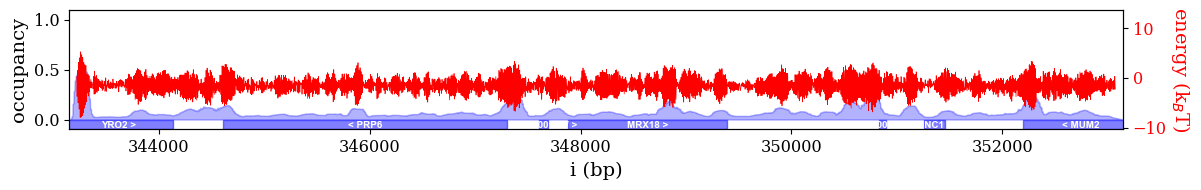

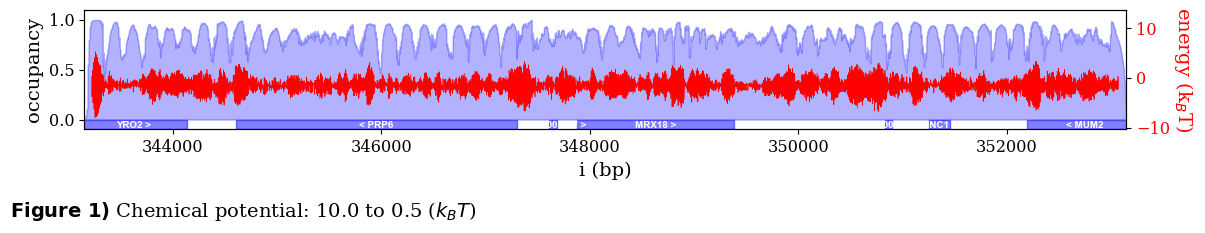

In [3]:
plotter = SequencePlotter()

mus = np.linspace(10.0, 0.5, 2)
for mu in mus:
    fiber.calc_energy_landscape(amplitude=0.05, period=9.7, chemical_potential=mu)
    plotter.plot(fiber, energy=True, orfs=True)

plotter.add_caption(f"Chemical potential: {mus[0]} to {mus[1]} ($k_BT$)")
plt.show()

Sampling fibers and calculating methylation: 100%|██████████| 500/500 [00:11<00:00, 43.36it/s]


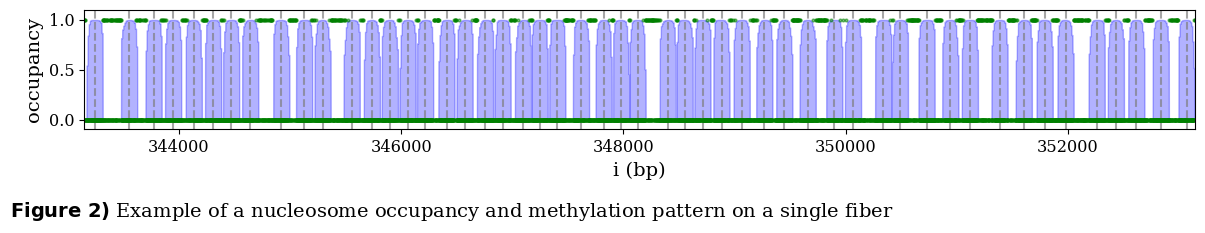

In [4]:
n = 500
methylated = []
for i in tqdm(range(n), desc="Sampling fibers and calculating methylation"):
    dyads = fiber.sample_fiber_configuration()
    methylation = fiber.calc_methylation(
        dyads, efficiency=0.4, e_contact=-0.9, steric_exclusion=7
    )
    methylated.append(methylation.methylated)

plotter.plot(
    fiber,
    dyads=dyads,
    occupancy=methylation.protected,
    methylation=methylation.methylated,
)

plotter.add_caption(
    "Example of a nucleosome occupancy and methylation pattern on a single fiber"
)
plt.show()

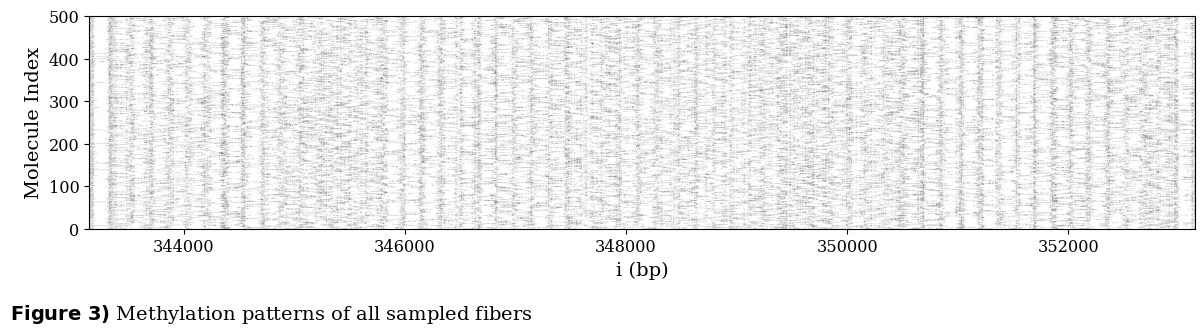

In [5]:
plt.figure(figsize=(12, 3))
plt.imshow(
    np.asarray(methylated) == 1,
    aspect="auto",
    cmap="Greys",
    extent=(
        fiber.index[0].astype(float),
        fiber.index[-1].astype(float),
        0,
        len(methylated),
    ),
)
plt.xlabel("i (bp)")
plt.ylabel("Molecule Index")
plt.tight_layout()
plotter.add_caption("Methylation patterns of all sampled fibers")
plt.show()

Plotting footprints: 50it [00:02, 20.81it/s]


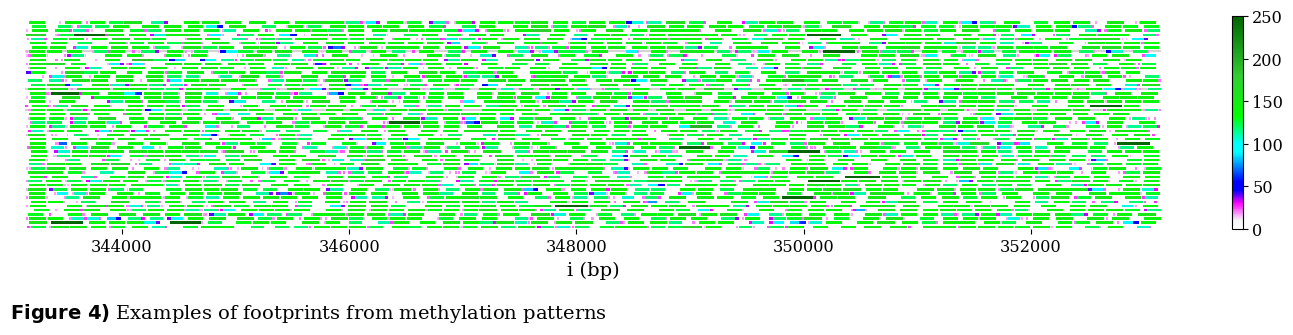

In [6]:
footprints = convert_to_footprints(methylated, fiber.index, minimal_footprint=15)

plot_footprints(footprints, fiber.index, n_max=50)

plotter.add_caption("Examples of footprints from methylation patterns")

plt.show()

Calculating correlation: 100%|██████████| 500/500 [00:19<00:00, 25.85it/s]


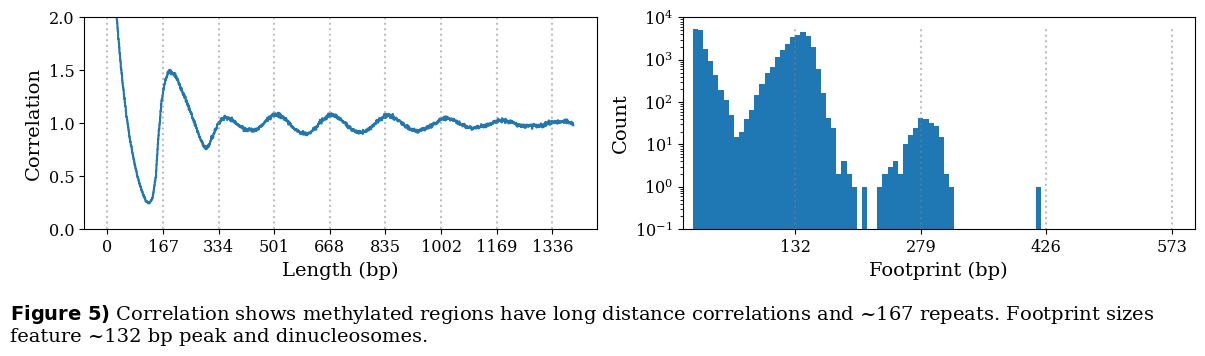

In [7]:
bins = np.arange(0, 1401, 1).astype(float)
correlation = np.zeros_like(bins[:-1])

for m in tqdm(methylated, desc="Calculating correlation"):
    t = fiber.index.astype(float)[np.where(m == 1)]
    correlation += pcorrelate(t, t, bins, normalize=True)


vlines = np.arange(0, np.max(bins).astype(int), 167)

plt.figure(figsize=(12, 3))
# make two figures next to each other
plt.subplot(1, 2, 1)
plt.plot(bins[:-1], correlation / len(methylated), drawstyle="steps-post")

plt.xticks(vlines, labels=[str(x) for x in vlines])
plt.vlines(vlines, ymin=0, ymax=2, colors="gray", linestyles="dotted", alpha=0.5)
plt.xlabel("Length (bp)")
plt.ylabel("Correlation")
plt.ylim(0, 2)

# go to second figure
plt.subplot(1, 2, 2)
maxwidth = 600
plt.xlim(0, maxwidth)
plt.hist(footprints["width"].values, bins=100, range=(0, maxwidth))
plt.xlabel("Footprint (bp)")
plt.ylabel("Count")
xticks = np.arange(0, maxwidth, 147) - 15
plt.xticks(xticks, labels=[str(x) for x in xticks])
plt.vlines(
    xticks,
    ymin=0,
    ymax=plt.gca().get_ylim()[1],
    colors="gray",
    linestyles="dotted",
    alpha=0.5,
)
plt.xlim(0, maxwidth)
plt.yscale("log")
plt.ylim(1e-1, 1e4)
plt.tight_layout()
plotter.add_caption(
    "Correlation shows methylated regions have long distance correlations and ~167 repeats."
    + " Footprint sizes feature ~132 bp peak and dinucleosomes."
)
plt.show()

In [15]:
methylated_sequence = fiber.encode_methylations(methylation.methylated)
ic(methylated_sequence[:200])

ic| methylated_sequence[:200]: 'tcAAAaTtaatccAccaaccggtgctgatttccacattacatctcgtggttcagactggcttttcaccgttttttgtgttaacctactattcggtgtgattttagtcccactaatgtttagaaaaccagttaaggacagattcgtatattatacggccattgctccaaattTgTTcATgtcAattgctTatTtcAccatg'


'tcAAAaTtaatccAccaaccggtgctgatttccacattacatctcgtggttcagactggcttttcaccgttttttgtgttaacctactattcggtgtgattttagtcccactaatgtttagaaaaccagttaaggacagattcgtatattatacggccattgctccaaattTgTTcATgtcAattgctTatTtcAccatg'